In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold

from load_data import create_eeg_data

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
import pickle
from scipy.stats import zscore

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd
from PIL import Image

%matplotlib inline

In [2]:
#set path
#path = 'D:/NISE_project_data/eeg-motor-movementimagery-dataset-1.0.0/files/'
path = '/home/matthijspals/physionet.org/files/eegmmidb/1.0.0'


In [3]:
def create_spectrogram(epochs,trial,frequencies=np.arange(8, 30, 1),n_cycles=10,average=False,tmin=0.25,tmax=4,verbose=True, n_ch=3):
    power = mne.time_frequency.tfr_morlet(epochs ,n_cycles=n_cycles,
                                      freqs=frequencies, average=False, return_itc=False,verbose=False, use_fft=True)
    times=np.linspace(start=tmin,stop=tmax,num=epochs.get_data().shape[2])
    if verbose:
        #plt.figure(figsize=(15, 10))
        #plt.subplot(1,3,1)
        #plt.pcolormesh(times,frequencies,power.data[trial,0,:,:])
        #plt.subplot(1,3,2)
        #plt.pcolormesh(times,frequencies,power.data[trial,1,:,:])
        #plt.subplot(1,3,3)
        #plt.pcolormesh(times,frequencies,power.data[trial,2,:,:])
        img=plt.imshow(power.data[trial,0:n_ch,:,:].reshape(n_ch*frequencies.shape[0],601),aspect="auto",origin="lower")
    
    return power.data[trial,0:n_ch,:,:].reshape(n_ch*frequencies.shape[0],601),img #(trials,channels,spectogram1,spectogram2)

def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

Preprocessing

/home/matthijspals/physionet.org/files/eegmmidb/1.0.0/S001/
Used Annotations descriptions: ['T0']
Not setting metadata
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


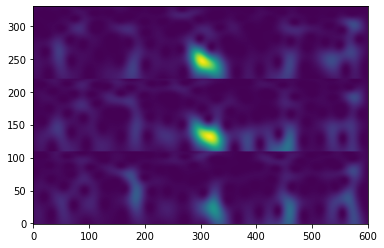

In [4]:
#participants = [1, 2, 3, 6, 7, 12, 14, 15, 18, 20, 21, 22, 29, 30, 31, 32, 33, 36, 37, 40]
n_ch = 3
participants =[1]
tmax = 4
tmin = -0.25
fs = 160.
trials=21
samples = int((tmax+tmin)*fs+1)
data = np.zeros((0,samples,n_ch))
labels = np.zeros(0)
lfreq, hfreq= 8, 30
freq_spec =  np.logspace(*np.log10([lfreq, hfreq]), num=110)
part_idx=0
n_cycles = freq_spec/2
im_chan=4
for part in participants:

    #load and filter data
    eeg_data = create_eeg_data(path, part = part, task = [0,1,0,1],baseline=True, filt=[lfreq,hfreq])
    epochs2 = eeg_data['t2'][0].all_sessions().copy().pick_channels(["C3","Cz","C4"])
    epochs4 = eeg_data['t4'][0].all_sessions().copy().pick_channels(["C3","Cz","C4"])
    raw0 = eeg_data['cl_eyes'][0].copy().pick_channels(["C3..","Cz..","C4.."])



    count = 0
    
    sampl = np.random.randint(low=0, high=eeg_data["cl_eyes"][0].get_data().shape[1]-samples, size=(trials,), dtype='l')
    events_array = np.zeros([trials,samples,n_ch])
    raw0 = eeg_data['cl_eyes'][0].copy().pick_channels(["C3..","Cz..","C4.."])
    count = 0
    events=[]
    for i in range(trials):
        events_array[i,:,:]=raw0.get_data()[:,sampl[count]:sampl[count]+samples].T
        
        count = count+1
    labels0 = np.zeros([trials,])
    info = mne.create_info(["C3","Cz","C4"], fs, ch_types='eeg', verbose=False)
    new_baseline_raw=mne.io.RawArray(events_array.reshape([3,trials*samples]),info,verbose=False)
    onsets=np.arange(0,new_baseline_raw.get_data().shape[1]/fs,samples/fs)
    duration = np.ones([trials,])*(samples/fs)
    description = []
    for i in range(trials):
        description.append("T0")

    annot_base= mne.Annotations(onset=onsets,duration=duration,description=description)
    new_baseline_raw = new_baseline_raw.copy().set_annotations(annot_base)
    epochs0 = mne.EpochsArray(events_array.transpose([0,2,1]), info, events=mne.events_from_annotations(new_baseline_raw,
                                    event_id={"T0":0})[0], tmin=0.25, event_id=None, reject=None, flat=None, reject_tmin=None,
                                    reject_tmax=None, baseline=None, proj=True, on_missing='raise', metadata=None, 
                                      selection=None, verbose=None)
    epochs0.info["highpass"]=8
    epochs0.info["lowpass"]=30
    
    
    spec_data_train0 = np.zeros([len(participants),trials,n_ch*freq_spec.shape[0],samples])
    img_data_train0 = np.zeros([len(participants),trials,n_ch*freq_spec.shape[0],samples,im_chan]) 
    for i in range(trials):
        spec_data_train0[part_idx,i,:,:],img0=create_spectrogram(epochs0,i,frequencies=freq_spec,n_cycles=n_cycles,verbose=True)
        img_data_train0[part_idx,i,:,:,:]= img0.cmap(img0.norm(img0.get_array()))
    #create training epochs
    epochs_train2 = epochs2.copy().crop(tmin=-tmin, tmax=tmax)
    spec_data_train2 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples]) 
    img_data_train2 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples,im_chan]) 
    for i in range(trials*2):
            spec_data_train2[part_idx,i,:,:],img2=create_spectrogram(epochs_train2,i,frequencies=freq_spec,n_cycles=n_cycles,verbose=True)
            img_data_train2[part_idx,i,:,:,:]= img2.cmap(img2.norm(img2.get_array()))
    labels2 = epochs2.events[:, -1] - 1
    epochs_data_train2 = epochs_train2.get_data().transpose([0,2,1])
    
    epochs_train4 = epochs4.copy().crop(tmin=-tmin, tmax=tmax)
    
    spec_data_train4 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples])
    img_data_train4 = np.zeros([len(participants),trials*2,n_ch*freq_spec.shape[0],samples,im_chan])
    for i in range(trials*2):
            spec_data_train4[part_idx,i,:,:],img4=create_spectrogram(epochs_train4,i,frequencies=freq_spec,n_cycles=n_cycles,verbose=True)
            img_data_train4[part_idx,i,:,:,:]= img4.cmap(img4.norm(img4.get_array()))
            
    labels4 = epochs4.events[:, -1] +1
    epochs_data_train4 = epochs_train4.get_data().transpose([0,2,1])

    #concatenate to bigg file
    labels240 = np.concatenate((labels2, labels4,labels0))
    #data24 = np.concatenate((epochs_data_train2, epochs_data_train4, epochs_data_train0),axis=0)
    spec240 = np.concatenate((spec_data_train2,spec_data_train4,spec_data_train0),axis=1)
    img240 = np.concatenate((img_data_train2,img_data_train4,img_data_train0),axis=1)
    #data = np.concatenate((data, data24))
    part_idx = part_idx+1
    with open('data.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    with open('labels.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(labels, f, pickle.HIGHEST_PROTOCOL)

In [5]:
#USE ONLY TASK 2 FOR NOW
#------------------

#img240 = img_data_train2.squeeze()[:,:,:,0:3]

In [6]:
"""
#IMAGE COMPRESSION AND NORMALIZATION

#for i in range(np.shape(img240)[0]):
#    for freq in range(np.shape(img240)[1]):
#            img240[i, freq] #-= np.mean(img240[i, freq])
#            img240[i, freq] /= np.var(img240[i, freq])
            #img240[i, freq] -= np.min(img240[i, freq])

img_comp = (np.zeros((np.shape(img240)[0],66,66, 3)))
for i in range(np.shape(img240)[0]):
    img_comp[i] =  cv2.resize(img240[i], dsize=(66, 66), interpolation=cv2.INTER_CUBIC)
#img_comp -= np.min(img_comp)
img_comp /=np.max(img_comp)
#img_comp = np.expand_dims(img_comp, axis = 3)
"""

'\n#IMAGE COMPRESSION AND NORMALIZATION\n\n#for i in range(np.shape(img240)[0]):\n#    for freq in range(np.shape(img240)[1]):\n#            img240[i, freq] #-= np.mean(img240[i, freq])\n#            img240[i, freq] /= np.var(img240[i, freq])\n            #img240[i, freq] -= np.min(img240[i, freq])\n\nimg_comp = (np.zeros((np.shape(img240)[0],66,66, 3)))\nfor i in range(np.shape(img240)[0]):\n    img_comp[i] =  cv2.resize(img240[i], dsize=(66, 66), interpolation=cv2.INTER_CUBIC)\n#img_comp -= np.min(img_comp)\nimg_comp /=np.max(img_comp)\n#img_comp = np.expand_dims(img_comp, axis = 3)\n'

In [17]:
img_old = img240
img240 = img240.squeeze()[:,:,:,:3]
img_comp = (np.zeros((np.shape(img240)[0],66,66, 3)))
for i in range(np.shape(img240)[0]):
    img_comp[i] =  cv2.resize(img240[i], dsize=(66, 66), interpolation=cv2.INTER_CUBIC)
img_comp -= np.min(img_comp)
img_comp /=np.max(img_comp)
img240 = img_comp
#img_comp = np.expand_dims(img_comp, axis = 3)

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)


In [19]:
for train_index, test_index in sss.split(img240.squeeze(), labels240):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = img240.squeeze()[train_index,:,:,:3], img240.squeeze()[test_index,:,:,:3]
    y_train, y_test = labels240[train_index], labels240[test_index]

TRAIN: [ 86  87   2   6  28  65  52  10   0  56  88  40  90  57  92  31  85  24
  41  70  98  26  76  47  66  38  11  83  45  27  84  19  53  62  94 100
  81   3  63  16  13  74  44  34   4  69   8  60   1   5  54  22  72  97
  91  12  64  14  46  32  75  51   7  59  39 104  96  49  33  68  25  35
  20  37  82 103  79  23  77 101  67  71 102  48] TEST: [ 9 50 89 73 17 30 36 95 18 93 21 99 29 61 80 55 78 58 42 43 15]


In [20]:
#ONE HOT ENCODING
from keras.utils import to_categorical
y_train_OH = to_categorical(y_train)
y_test_OH = to_categorical(y_test)


In [21]:
#X_train, X_test, y_train, y_test = train_test_split(img240.squeeze()[:,:,:,0:3], labels240, test_size=0.20)

In [22]:
#np.savez("db/x_norm", X_train[:10], allow_pickle=True)
#np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

In [23]:
""""""
np.savez_compressed("x_train", X_train)
np.savez_compressed("x_test", X_train)
np.savez_compressed("x_norm", X_train)
np.savez_compressed("y_train", y_train_OH)
np.savez_compressed("y_test", y_train_OH)

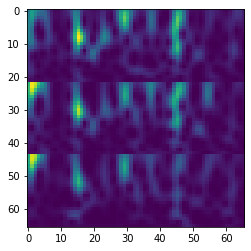

In [24]:
plt.imshow(X_test[0])

In [25]:
#from keras.models import Sequential, InputLayer
#from keras.layers import Dense, Activation, Flatten
#from keras.layers import BatchNormalization, Dropout, Conv2D, MaxPooling2D
#from tensorflow import keras

#from tensorflow.keras import Sequential, Input
#from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, \
    Dropout


input_shape = X_test[0].shape
input_layer = Input(input_shape)

layer = Conv2D(filters=16,
               kernel_size=(5, 5),
               strides=(2, 2),
               activation='relu',
               use_bias=False)(input_layer)

layer = Conv2D(filters=32,
               kernel_size=(3, 3),
               activation='relu',
               use_bias=False)(layer)
#layer = AveragePooling2D()(layer)
layer = Conv2D(filters=8,
               kernel_size=(3, 3),
               padding='same',
               activation='relu',
               use_bias=False)(layer)

layer = Flatten()(layer)
layer = Dropout(0.01)(layer)
layer = Dense(units=5,
              activation='softmax')(layer)

model = Model(input_layer, layer)

# compile the model
opt = Adam(learning_rate = 1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
#print(model.summary())


In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 66, 66, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 16)        1200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4608      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 8)         2304      
_________________________________________________________________
flatten (Flatten)            (None, 6728)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6728)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [36]:
batch_size=16
no_epochs= 10
# Fit data to model
history = model.fit(X_train,  y_train_OH,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=True,
        validation_data=(X_test, y_test_OH))

# Generate generalization metrics
scores = model.evaluate(X_test, y_test_OH, verbose=1)



Epoch 1/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.5303 - val_accuracy: 0.6190
Epoch 2/10
6/6 [==============================] - 0s 28ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.5350 - val_accuracy: 0.5714
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.4715 - val_accuracy: 0.6190
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.4571 - val_accuracy: 0.6190
Epoch 5/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.4591 - val_accuracy: 0.6190
Epoch 6/10
6/6 [==============================] - 0s 27ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.5250 - val_accuracy: 0.6190
Epoch 7/10
6/6 [==============================] - 0s 32ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.6019 - val_accuracy: 0.6190
Epoch 8/10
6/6 [===========

In [41]:
np.shape(X_test[0].ravel())

(13068,)

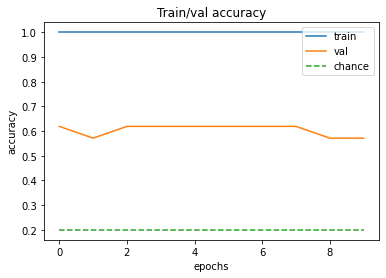

In [38]:
%matplotlib inline
#plot accuracy\
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'val')
plt.plot(np.ones(len(history.history['accuracy']))*0.2, '--', label = 'chance')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Train/val accuracy")
plt.legend()

In [40]:
save_model = True
if save_model:
    model.save("CNN1.h5", save_format = 'h5')